
# MSM of Brownian dynamics simulations of diffusion on a 2D mueller potential
The mueller potential was introduced by K. Muller and L. D. Brown in Theo. Chim. Acta (Berl.) 53, 75-93 (1979):
\begin{equation}
    V(x) = \sum_{j=1}^{4}A_{j} \cdot exp(a_{j}(x_{1}-X_{j})^{2}+b_{j}(x_{1}-X_{j})(x_{2}-Y_{j})+c_{j}(x_{2}-Y_{j})^{2})
\end{equation}
where a=(-1,-1,-6.5,0.7); b=(0, 0, 11, 0.6); c=(-10,-10,-6.5, 0.7); A=(-200,-100,-170, 15); X=(1, 0,-0.5,-1); Y=(0, 0.5, 1.5, 1)

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import time
import itertools
import numpy as np
import scipy.stats
from scipy.optimize import curve_fit
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})
from collections import OrderedDict

Read trajectory from COSSIO generator

In [3]:
import h5py
import sys
sys.path.append('/home/imitxelena003/Programs/msm/smFS/smfs/')
import cossio
h5file = "data/mueller_x-1_y0.5_dt0.0001.h5"
f = h5py.File(h5file, 'r')
data = np.array(f['data'])
f.close()

### Trajectory analysis and assignment
We discretize the trajectory by a 2D binning, so the mueller potential is divided in microstates (plot 1). In consequence, both x and y coordinates merge onto a s coordinate (plot 2).

<function matplotlib.pyplot.show(*args, **kw)>

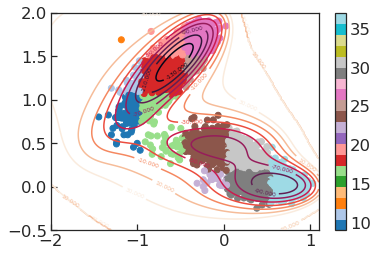

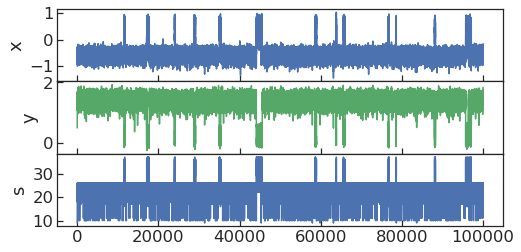

In [4]:
discret = np.zeros(data.shape[0])
statistic, x_edge, y_edge, binnumber = \
    scipy.stats.binned_statistic_2d(data[:,1],data[:,2],discret,'count', \
    bins=[np.linspace(np.amin(data[:,1]),np.amax(data[:,1]),6), \
    np.linspace(np.amin(data[:,2]),np.amax(data[:,2]),6)],expand_binnumbers=False)

y = np.linspace(-0.5,2.,200)
x = np.linspace(-2.,1.1,200)
M = np.zeros((len(x), len(y)))
lines = []
for i, x_i in enumerate(x):
    for j, y_i in enumerate(y):
        aux = cossio.fmueller(x_i,y_i)
        if aux<100: M[i, j] = aux
X, Y = np.meshgrid(x,y)
fig, ax = plt.subplots()
levels = np.arange(-130.0, 40.0, 20)
CS = ax.contour(X, Y, M.T, levels)
ax.clabel(CS, inline=0.9, fontsize=6)
cmaps = OrderedDict()
cmaps['Qualitative'] = ['Pastel1', 'Pastel2', 'Paired', 'Accent', \
                        'Dark2', 'Set1', 'Set2', 'Set3', \
                        'tab10', 'tab20', 'tab20b', 'tab20c']
plt.scatter(data[:,1],data[:,2],c=binnumber,cmap=plt.get_cmap('tab20'))
plt.colorbar()
plt.show

fig,ax=plt.subplots(3,1,figsize=(8,4),sharex=True)
plt.subplots_adjust(wspace=0, hspace=0)
ax[0].plot(range(0,len(data[:,1])),data[:,1])
ax[1].plot(range(0,len(data[:,2])),data[:,2],color="g")
ax[2].plot(binnumber)
ax[0].set_ylabel('x')
ax[1].set_ylabel('y')
ax[2].set_ylabel("s")
plt.show

### MSM: convergence test
First, we build an instance of TimeSeries to find the strongly connected states corresponding to the assignment shown above.
Then, we study the dependence of the relaxation times on the lag time adopted to build the transition matrix.

     # states: 18
 symmetrizing
 symmetrizing
 symmetrizing
 symmetrizing
 symmetrizing


<function matplotlib.pyplot.show(*args, **kw)>

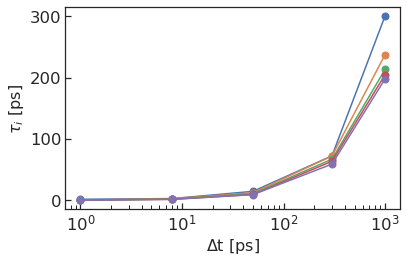

In [5]:
# MASTER EQUATION MODEL
from mastermsm.trajectory import traj
from mastermsm.msm import msm
distraj = traj.TimeSeries(distraj=list(binnumber), dt=1)
distraj.find_keys()
distraj.keys.sort()
msm_2D = msm.SuperMSM([distraj],sym=True)

# CONVERGENCE test
import random
rand = lambda: random.randint(0, 255)
msm_2D.convergence_test(time=[1, 8, 50, 300, 1000], error=False)#, 5000
fig, ax = plt.subplots()
for i in range(1,6):
    clr = '#%02X%02X%02X' % (rand(),rand(),rand())
    tau_vs_lagt = np.array([[x,msm_2D.msms[x].tauT[i]] \
               for x in sorted(msm_2D.msms.keys())])
    plot, = ax.plot(tau_vs_lagt[:,0],tau_vs_lagt[:,1],marker='o',ms=7)
ax.set_xlabel(r'$\Delta$t [ps]', fontsize=16)
ax.set_ylabel(r'$\tau_i$ [ps]', fontsize=16)
_ = ax.set_xscale('log')
plt.tight_layout()
plt.show


### MSM: validation
Once a proper lag time is chosen, we generate a MSM and plot the autocorrelation corresponding to the left eigenvectors (Buchete et al. JPCB 2008), as well as the spectrum of (logarithm of) relaxation times.

 symmetrizing


<function matplotlib.pyplot.show(*args, **kw)>

/home/imitxelena003/Programs/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


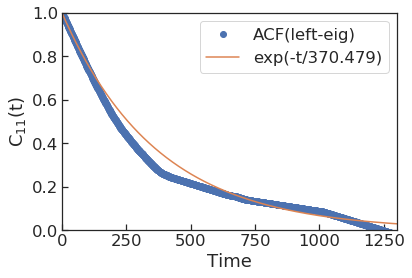

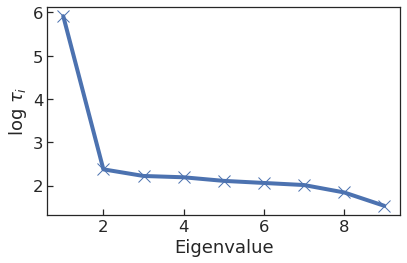

In [6]:
lagt=40
msm_2D.do_msm(lagt)
msm_2D.msms[lagt].do_trans(evecs=True)

# VALIDATION - AUTOCORRELATION FUNCTION (acf)
acf = msm_2D.msms[lagt].acf_mode()
time = np.arange(len(acf[1]))*msm_2D.data[0].dt
fig, ax = plt.subplots()
ax.plot(time, acf[1], 'o', label='ACF(left-eig)')
ax.plot(time,np.exp(-time*1./msm_2D.msms[lagt].tauT[0]), \
            label='exp(-t/%5.3f)' % msm_2D.msms[lagt].tauT[0])
ax.set_ylim(0,1)
ax.set_xlim(0,1300)
ax.set_xlabel('Time')
ax.set_ylabel('C$_{11}$(t)')
ax.legend()
plt.show

# Spectrum of relaxation times
fig, ax = plt.subplots()
ax.plot(range(1,len(msm_2D.msms[lagt].tauT)+1), \
            np.log(msm_2D.msms[lagt].tauT), 'x-', markersize=12, linewidth=4)
ax.set_xlabel('Eigenvalue')
ax.set_ylabel(r'log $\tau_i$')
plt.tight_layout()
plt.show

The first mode captured by $\lambda_1$ is significantly slower than the others. That mode, which is described by the right eigenvector $\psi^R_1$ as the transition between the two main minima. Next plots correspond to the eigenvector and its projection on the mueller potential.

<function matplotlib.pyplot.show(*args, **kw)>

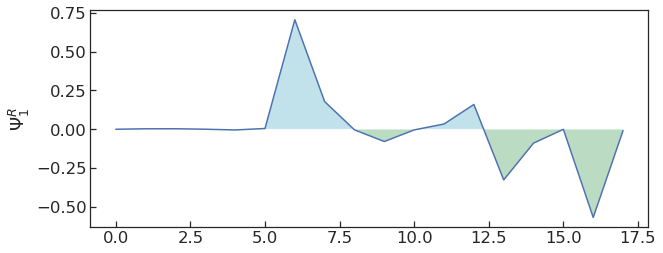

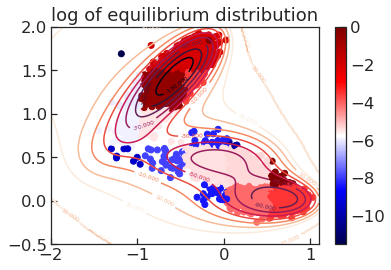

In [7]:
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(msm_2D.msms[lagt].rvecsT[:,1])
ax.fill_between(range(len(msm_2D.msms[lagt].rvecsT[:,1])), 0, \
                msm_2D.msms[lagt].rvecsT[:,1], \
                where=msm_2D.msms[lagt].rvecsT[:,1]>0,\
                facecolor='c', interpolate=True,alpha=.4)
ax.fill_between(range(len(msm_2D.msms[lagt].rvecsT[:,1])), 0, \
                msm_2D.msms[lagt].rvecsT[:,1], \
                where=msm_2D.msms[lagt].rvecsT[:,1]<0,\
                facecolor='g', interpolate=True,alpha=.4)
ax.set_ylabel("$\Psi^R_1$")
plt.show

# 2D projection
binnumber2 = np.zeros(len(data[:,1]))
for i in range(len(binnumber)-1):
    j = binnumber[i]
    for k in range(len(msm_2D.msms[lagt].keep_keys)-1):
        if j==msm_2D.msms[lagt].keep_keys[k]:
            binnumber2[i] = np.log(msm_2D.msms[lagt].peqT[k])
            break
y = np.linspace(-0.5,2.,200)
x = np.linspace(-2.,1.1,200)
M = np.zeros((len(x), len(y)))
lines = []
for i, x_i in enumerate(x):
    for j, y_i in enumerate(y):
        aux = cossio.fmueller(x_i,y_i)
        if aux<100: M[i, j] = aux
X, Y = np.meshgrid(x,y)
fig, ax = plt.subplots()
levels = np.arange(-130.0, 40.0, 20)
CS = ax.contour(X, Y, M.T, levels)
ax.clabel(CS, inline=0.9, fontsize=6)
cmaps = OrderedDict()
cmaps['Diverging'] = ['PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu',
            'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']
plt.scatter(data[:,1],data[:,2],c=binnumber2,cmap=plt.get_cmap('seismic'))
plt.colorbar()
plt.title('log of equilibrium distribution')
plt.show